# Initialisation and utilities

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.linalg as lin
import scipy.sparse as sp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from tqdm import tqdm

In [6]:
def create_plot(xlabel, ylabel, xlim, ylim=[], title='', logx=False, logy=False, figsize=plt.rcParams.get('figure.figsize'), grid=True, axis_size=13, legend_size=11, tick_size=11) :

    plt.rc('axes',labelsize=axis_size)
    plt.rc('legend',fontsize=legend_size)
    plt.rc('xtick',labelsize=tick_size)
    plt.rc('ytick',labelsize=tick_size)
    plt.rc('font',size=legend_size)

    plt.figure(figsize=figsize)
    plt.tick_params(top=True,right=True,labeltop=False,labelright=False)

    plt.xlim(xlim)
    if len(ylim) != 0 : plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(title)

    if grid :
        plt.grid(visible=True, which="major", axis="both", linestyle="-", alpha=0.2, color="black",zorder=0)
        plt.grid(visible=True, which="minor", axis="both", linestyle="--", alpha=0.2, color="black",zorder=0)

    if logx :
        plt.xscale('log')

    if logy :
        plt.yscale('log')

# Tools for Monte-Carlo simulation of 3D Ising model

In [4]:
def random_lattice3D(Nx, Ny, Nz) : # generate random 3D lattice 

    lattice = np.array([[[1 if np.random.uniform()<0.5 else -1 for i in range(Nx)] for j in range(Ny)] for k in range(Nz)])

    return lattice


def energy3D(config, J, Gamma, beta) : # compute the energy of the configuration config at temperature beta
 
    Nx,Ny,Nz = np.shape(config)
    Km = 0.5*Nz/beta*np.log(1/np.tanh(beta*Gamma/Nz))

    H1 = 0
    H2 = 0

    for k in range(Nz) :
        for i in range(Nx) :
            for j in range(Ny) :
                H1 += config[i,j,k]*(config[(i+1)%Nx,j,k] + config[i,(j+1)%Ny,k])
                H2 += config[i,j,k]*config[i,j,(k+1)%Nz]

    return -J/Nz*H1 - Km*H2


def mag3D(config) : # compute magnetization of a config
    return np.sum(config)


def delta_energy_flip3D(config, a, b, c, J, Gamma, beta) : # compute the energy difference generated by the flip of a spin at position a,b,c

    Nx,Ny,Nz = np.shape(config)
    Km = 0.5/beta*np.log(1/np.tanh(beta*Gamma/Nz))

    dE = 2*config[a,b,c]*(J/Nz*(config[(a+1)%Nx,b,c] + config[a,(b+1)%Ny,c] + config[(a-1)%Nx,b,c] + config[a,(b-1)%Ny,c]) + Km*(config[a,b,(c+1)%Nz] + config[a,b,(c-1)%Nz]))
    
    return dE


def MC_step3D(config, J, Gamma, beta) : # perform a whole sweep of the lattice by flipping N times a randomly chosen spin and checking the likelihood of this new configuration

    Nx,Ny,Nz = np.shape(config)

    for i in range(Nx*Ny*Nz) :
        # flip one randomly chosen site

        a = np.random.randint(low=0,high=Nx)
        b = np.random.randint(low=0,high=Ny)
        c = np.random.randint(low=0,high=Nz)

        dE = delta_energy_flip3D(config,a,b,c,J,Gamma,beta)

        if dE<0 :
            config[a,b,c] *= -1

        else :

            p = np.exp(-beta*dE)

            if np.random.uniform() < p: # accept candidate if alpha>=1 or accept candidate with proba alpha if 0<alpha<1

                config[a,b,c] *= -1            
                
    return config


def MC_configurations(Nx, Ny, Nz, J, Gamma, beta, Neq, Nsteps, initial_config, plot_MC = False) : # generate Nsteps spin configurations with the MC algorithm with Neq equilibration steps 

    M_burnin = np.zeros(Neq+Nsteps)        

    config = initial_config

    # reach equilibrium
    for j in range(Neq) :
        config = MC_step3D(config,J,Gamma,beta)
        M_burnin[j] = np.abs(mag3D(config))

    # sample for average
    for k in range(Nsteps) :
        config = MC_step3D(config,J,Gamma,beta)
        M_burnin[Neq+k] = np.abs(mag3D(config))
    
    if plot_MC :
        create_plot('MC step',r'$|m|$',[1,Neq+Nsteps],ylim=[np.min(M_burnin/(Nx*Ny*Nz))-0.1,np.max(M_burnin/(Nx*Ny*Nz))+0.1],logx=True,title=r'$T/J=$'+str(1/beta)+r', $\Gamma/J=$'+str(Gamma))
        plt.plot(range(Neq+Nsteps-1),M_burnin[:-1]/(Nx*Ny*Nz))
        plt.plot([Neq,Neq],[np.min(M_burnin/(Nx*Ny*Nz))-0.1,np.max(M_burnin/(Nx*Ny*Nz))+0.1],'--',color='black')

    Mt = M_burnin[Neq:]

    return Mt,config

# Monte-Carlo process

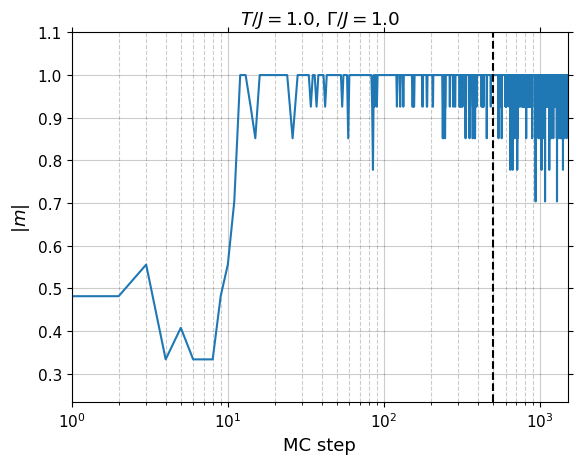

In [7]:
J = 1
Gamma = 1.
T = 1.

Nx, Ny, Nz = 3, 3, 3

Neq = 500
Nsteps = 1000

initial_config = random_lattice3D(Nx,Ny,Nz)

Mt,config = MC_configurations(Nx,Ny,Nz,J,Gamma,1/T,Neq,Nsteps,initial_config,plot_MC=True) # returns the magnetisation after each Monte-Carlo sweep (removing equilibration time) and the last obtained configuration

In [43]:
# Compute average magnetisation per spin and susceptibility

M = np.sum(Mt)/(Nx*Ny*Nz*Nsteps)
chi = np.sum(Mt**2)/((Nx*Ny*Nz)**2*Nsteps) - M**2

print(M,chi)

0.9800740740740741 0.00203368449931407


# Phase transitions

## Thermal transition

In [52]:
J = 1
Gamma = [1.]
T = np.linspace(0.5,6,25)

Nx, Ny, Nz = 3, 3, 3

Neq = 500
Nsteps = 5000


M = np.zeros((len(Gamma),len(T)))
chi = np.zeros((len(Gamma),len(T)))

last_config = np.ones((Nx,Ny,Nz))

for i in range(len(Gamma)) :
    gamma = Gamma[i]
    for j in tqdm(range(len(T))) :
        t = T[j]
        if i != 0 or j != 0 : Nequ = 0
        else : Nequ=Neq
        
        Mt,last_config = MC_configurations(Nx,Ny,Nz,J,gamma,1/t,Nequ,Nsteps,last_config)
        M[i,j] = np.sum(Mt)/Nsteps
        chi[i,j] = (np.sum(Mt**2)/Nsteps - M[i,j]**2)/t

100%|██████████| 25/25 [00:58<00:00,  2.34s/it]


/tmp/ipykernel_6081/681916154.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(T,chi[i,:],'.',label=r'$\Gamma/J=$'+str(gamma),color=colors[i],marker='.')


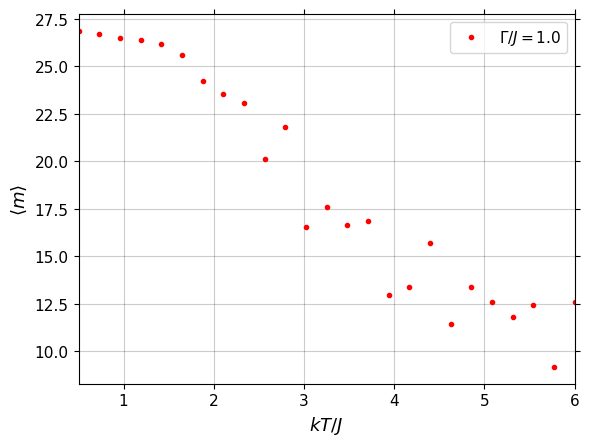

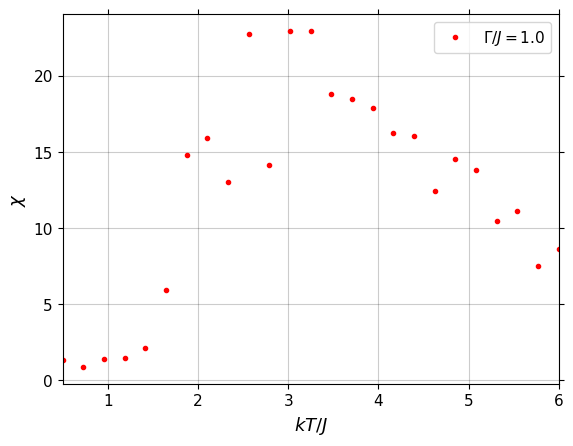

In [53]:
create_plot(r'$kT/J$',r'$\langle m\rangle$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']


for i,gamma in enumerate(Gamma) :
    plt.plot(T,M[i,:],'.',label=r'$\Gamma/J=$'+str(gamma),color=colors[i])
    plt.legend()


create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']

filters = np.array([[3,1],[5,3],[15,3]])

for i,gamma in enumerate(Gamma) :
    plt.plot(T,chi[i,:],'.',label=r'$\Gamma/J=$'+str(gamma),color=colors[i],marker='.')
    plt.legend()


plt.show()

## $\Gamma$ transitions

In [54]:
J = 1
Gamma = np.linspace(1,6,25)
T = [1.]

Nx, Ny, Nz = 3, 3, 4

Neq = 500
Nsteps = 1000


M = np.zeros((len(T),len(Gamma)))
chi = np.zeros((len(T),len(Gamma)))

last_config = np.ones((Nx,Ny,Nz))

for i in range(len(T)) :
    t = T[i]
    for j in tqdm(range(len(Gamma))) :
        gamma = Gamma[j]
        if i != 0 or j != 0 : Nequ = 0
        else : Nequ=Neq
        
        Mt,last_config = MC_configurations(Nx,Ny,Nz,J,gamma,1/t,Nequ,Nsteps,last_config)
        M[i,j] = np.sum(Mt)/Nsteps
        chi[i,j] = (np.sum(Mt**2)/Nsteps - M[i,j]**2)/t

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


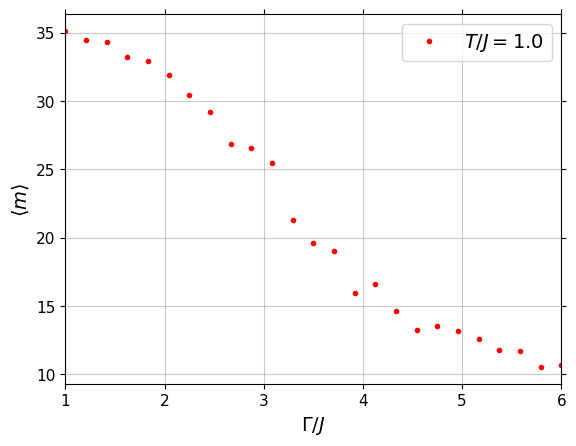

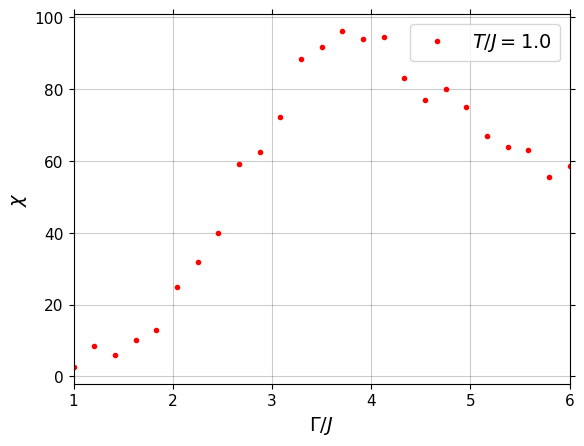

In [55]:
# Plot Mag

create_plot(r'$\Gamma/J$',r'$\langle m\rangle$',[Gamma[0],Gamma[-1]],legend_size=14,axis_size=14)

colors = ['r','b','g','o']

for i,t in enumerate(T):
    plt.plot(Gamma,M[i,:],'.',label=r'$T/J=$'+str(t),color=colors[i])
    plt.legend()


# Plot chi

create_plot(r'$\Gamma/J$',r'$\chi$',[Gamma[0],Gamma[-1]],legend_size=14,axis_size=14)

colors = ['r','b','g','o']

for i,t in enumerate(T) :
    plt.plot(Gamma,chi[i,:],'.',label=r'$T/J=$'+str(t),color=colors[i])
    plt.legend()


plt.show()